# Bootstrap Analysis: Confidence Intervals for Real Estate Statistics

**Objective:** Use bootstrap resampling to estimate confidence intervals for key real estate metrics.

**Methods:**
- Non-parametric bootstrap resampling
- Percentile confidence intervals
- BCa (Bias-Corrected and Accelerated) bootstrap

**Metrics:** Mean price, price trends, correlation stability

## Step 1: Import Libraries and Load Data

**What this does:**
- Imports pandas (data), numpy (math), matplotlib/seaborn (plotting), scipy (statistics)
- Loads the cleaned quarterly data we created in notebook 01
- Sets up logging and visualization style

**Why bootstrap?** Bootstrap is a statistical method that resamples your data with replacement to estimate confidence intervals. It's powerful because it doesn't assume your data follows a normal distribution (bell curve).

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import logging

sys.path.insert(0, str(Path(".").resolve().parent))
from helpers.data_processing import load_csv_file

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

data_path = Path("../data/processed/quarterly_construction_data_with_sales.csv")
df = load_csv_file(str(data_path))

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

logger.info(f"Loaded {df.shape[0]} quarters of data")
display(df.head())

INFO:helpers.data_processing:Loaded CSV from ../data/processed/quarterly_construction_data_with_sales.csv using utf-8 encoding
INFO:__main__:Loaded 48 quarters of data


,date,num_building_permits,construction_cost_index,num_residential_sales,avg_price_eur
0,2013-01-01,869.0,83.5,2345.0,80492.968443
1,2013-04-01,919.0,80.1,2601.0,82566.322568
2,2013-07-01,847.0,81.7,2008.0,77141.554283
3,2013-10-01,808.0,79.4,2285.0,74166.764114
4,2014-01-01,729.0,81.7,2345.0,71928.062687


## Step 2: Define Bootstrap Functions

**What this does:**
- Defines `calculate_bootstrap_confidence_interval()` - resamples data 10,000 times, calculates statistics each time, computes confidence intervals from the distribution
- Defines `calculate_bootstrap_regression_slope()` - estimates how fast price is changing (trend) with uncertainty

**Bootstrap resampling:**
1. Start with 48 quarters of price data
2. Randomly draw 48 quarters (with replacement—same quarter can be drawn multiple times)
3. Calculate mean of this sample
4. Repeat 10,000 times
5. Sort the 10,000 means; take 2.5th and 97.5th percentile = 95% confidence interval

**Why "with replacement"?** It allows the same data point to appear multiple times in a sample, which better reflects real-world uncertainty.

In [2]:
def calculate_bootstrap_confidence_interval(data, statistic_func, n_bootstrap=10000, alpha=0.05, random_state=42):
    """
    Calculate bootstrap confidence interval using percentile method.
    
    Args:
        data: Input data array
        statistic_func: Function to compute statistic on resampled data
        n_bootstrap: Number of bootstrap resamples
        alpha: Significance level (e.g., 0.05 for 95% CI)
        random_state: Random seed
    
    Returns:
        ci_lower, ci_upper: Confidence interval bounds
        bootstrap_stats: Bootstrap distribution
    """
    np.random.seed(random_state)
    bootstrap_stats = []
    n = len(data)
    
    for _ in range(n_bootstrap):
        resample_idx = np.random.choice(n, size=n, replace=True)
        bootstrap_stats.append(statistic_func(data[resample_idx]))
    
    bootstrap_stats = np.array(bootstrap_stats)
    ci_lower = np.percentile(bootstrap_stats, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_stats, (1 - alpha/2) * 100)
    
    return ci_lower, ci_upper, bootstrap_stats

def calculate_bootstrap_regression_slope(X, y, n_bootstrap=10000, alpha=0.05, random_state=42):
    """
    Bootstrap confidence interval for linear regression slope.
    
    Args:
        X: Independent variable(s)
        y: Dependent variable
        n_bootstrap: Number of bootstrap samples
        alpha: Significance level
        random_state: Random seed
    
    Returns:
        slope_ci: Confidence interval for slope
        bootstrap_slopes: Bootstrap distribution of slopes
    """
    np.random.seed(random_state)
    bootstrap_slopes = []
    n = len(X)
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        x_resample = X[idx]
        y_resample = y[idx]
        
        if x_resample.std() > 0:  # Avoid division by zero
            slope = np.corrcoef(x_resample, y_resample)[0, 1] * (y_resample.std() / x_resample.std())
            bootstrap_slopes.append(slope)
    
    bootstrap_slopes = np.array(bootstrap_slopes)
    ci_lower = np.percentile(bootstrap_slopes, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_slopes, (1 - alpha/2) * 100)
    
    return (ci_lower, ci_upper), bootstrap_slopes

logger.info("Bootstrap functions defined")

INFO:__main__:Bootstrap functions defined


## Step 3: Calculate Bootstrap Confidence Intervals for Key Statistics

**What this does:**
- Uses bootstrap to estimate 95% confidence intervals for:
  - **Mean price**: Average residential price across all quarters
  - **Median price**: Middle price (less affected by expensive outliers)
  - **Std dev**: Price variability (how much prices fluctuate)
  - **Mean permits & sales**: Average construction and market activity

**Beginner interpretation:**
- If CI = €99K - €116K, we're 95% confident the true mean price is somewhere in this range
- Narrow CI = stable market; Wide CI = uncertain/volatile market

In [3]:
prices = df['avg_price_eur'].dropna().values
permits = df['num_building_permits'].dropna().values
sales = df['num_residential_sales'].dropna().values
cost_index = df['construction_cost_index'].values

logger.info(f"Computing bootstrap CIs for {len(prices)} price observations")

ci_mean_price = calculate_bootstrap_confidence_interval(prices, np.mean, n_bootstrap=10000)

ci_median_price = calculate_bootstrap_confidence_interval(prices, np.median, n_bootstrap=10000)

ci_std_price = calculate_bootstrap_confidence_interval(prices, np.std, n_bootstrap=10000)

ci_mean_permits = calculate_bootstrap_confidence_interval(permits, np.mean, n_bootstrap=10000)

ci_mean_sales = calculate_bootstrap_confidence_interval(sales, np.mean, n_bootstrap=10000)

results = pd.DataFrame({
    'Metric': ['Mean Price (EUR)', 'Median Price (EUR)', 'Price Std Dev (EUR)', 'Mean Buildings', 'Mean Sales'],
    'Estimate': [prices.mean(), np.median(prices), prices.std(), permits.mean(), sales.mean()],
    'CI Lower (95%)': [ci_mean_price[0], ci_median_price[0], ci_std_price[0], ci_mean_permits[0], ci_mean_sales[0]],
    'CI Upper (95%)': [ci_mean_price[1], ci_median_price[1], ci_std_price[1], ci_mean_permits[1], ci_mean_sales[1]]
})

print("\nBootstrap Confidence Intervals (95%):")
print("="*90)
display(results.round(0))

logger.info("Bootstrap CIs computed successfully")

INFO:__main__:Computing bootstrap CIs for 48 price observations



Bootstrap Confidence Intervals (95%):


,Metric,Estimate,CI Lower (95%),CI Upper (95%)
0,Mean Price (EUR),107141.0,99046.0,115886.0
1,Median Price (EUR),97321.0,88656.0,107028.0
2,Price Std Dev (EUR),29588.0,23464.0,34030.0
3,Mean Buildings,1433.0,1338.0,1524.0
4,Mean Sales,3043.0,2876.0,3211.0


INFO:__main__:Bootstrap CIs computed successfully


## Step 4: Visualize Bootstrap Distributions

**What this does:**
- Creates histograms showing the distribution of bootstrap samples for mean, median, and std deviation
- Includes a Q-Q plot to check if data is normally distributed
- Red dashed line = point estimate; Green dotted lines = 95% confidence interval

**Beginner concept - Q-Q plot:** Compares your data to a normal distribution (bell curve). If points follow the diagonal line, data is normally distributed. Deviations suggest the data has heavier tails or asymmetry.

INFO:__main__:Bootstrap distributions visualization saved


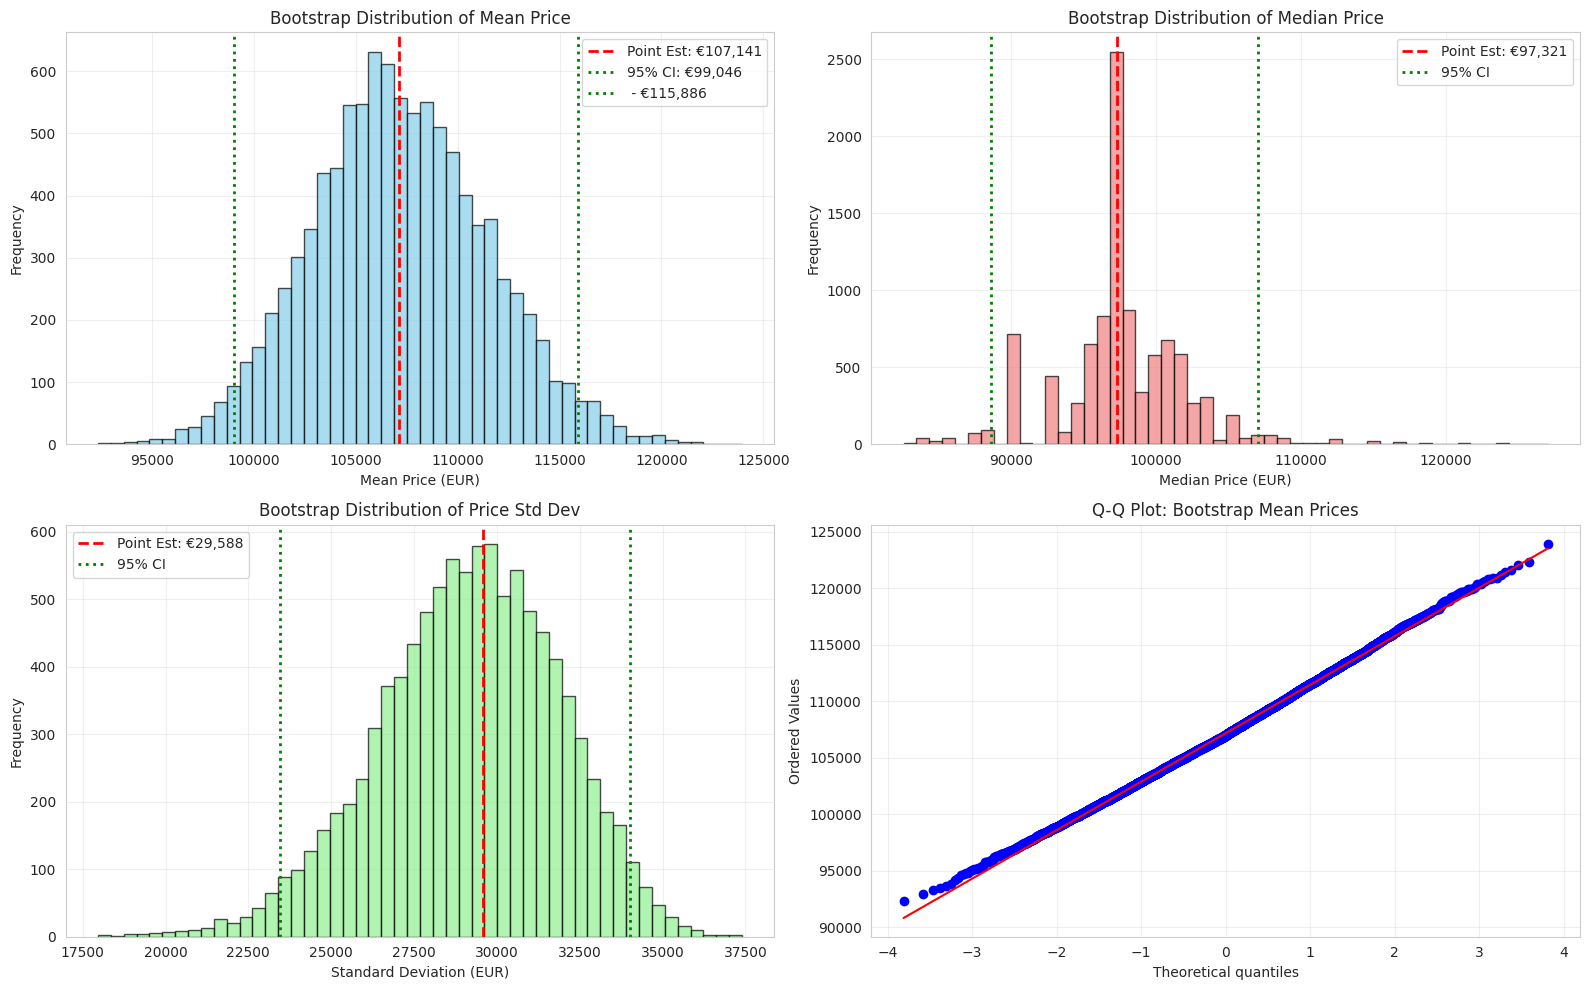

In [4]:
# Compute bootstrap distributions for visualization
_, _, bs_mean = calculate_bootstrap_confidence_interval(prices, np.mean, n_bootstrap=10000)
_, _, bs_median = calculate_bootstrap_confidence_interval(prices, np.median, n_bootstrap=10000)
_, _, bs_std = calculate_bootstrap_confidence_interval(prices, np.std, n_bootstrap=10000)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Bootstrap Distribution of Mean Price
ax = axes[0, 0]
ax.hist(bs_mean, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax.axvline(prices.mean(), color='red', linestyle='--', linewidth=2, label=f'Point Est: €{prices.mean():,.0f}')
ax.axvline(ci_mean_price[0], color='green', linestyle=':', linewidth=2, label=f'95% CI: €{ci_mean_price[0]:,.0f}')
ax.axvline(ci_mean_price[1], color='green', linestyle=':', linewidth=2, label=f' - €{ci_mean_price[1]:,.0f}')
ax.set_xlabel('Mean Price (EUR)')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution of Mean Price')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Bootstrap Distribution of Median Price
ax = axes[0, 1]
ax.hist(bs_median, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
ax.axvline(np.median(prices), color='red', linestyle='--', linewidth=2, label=f'Point Est: €{np.median(prices):,.0f}')
ax.axvline(ci_median_price[0], color='green', linestyle=':', linewidth=2, label=f'95% CI')
ax.axvline(ci_median_price[1], color='green', linestyle=':', linewidth=2)
ax.set_xlabel('Median Price (EUR)')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution of Median Price')
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Bootstrap Distribution of Std Dev
ax = axes[1, 0]
ax.hist(bs_std, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
ax.axvline(prices.std(), color='red', linestyle='--', linewidth=2, label=f'Point Est: €{prices.std():,.0f}')
ax.axvline(ci_std_price[0], color='green', linestyle=':', linewidth=2, label=f'95% CI')
ax.axvline(ci_std_price[1], color='green', linestyle=':', linewidth=2)
ax.set_xlabel('Standard Deviation (EUR)')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution of Price Std Dev')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Q-Q Plot
ax = axes[1, 1]
stats.probplot(bs_mean, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Bootstrap Mean Prices')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bootstrap/bootstrap_distributions.png', dpi=300, bbox_inches='tight')
logger.info("Bootstrap distributions visualization saved")
plt.show()

## Step 5: Analyze Price Trend Using Bootstrap

**What this does:**
- Estimates the slope (€/quarter) of the price trend line
- Uses bootstrap to get 95% CI for the slope
- Calculates probability that trend is positive (upward)

**Beginner concept - Slope:** If slope = €706/quarter, prices are rising ~€706 each quarter. Bootstrap tells us the range where the true slope likely lies.


Price Trend Analysis (Bootstrap):
  Original Slope Estimate: €1,990.20 per quarter
  95% CI: €1,709.45 - €2,261.92
  Bootstrap Mean: €1,989.65
  Bootstrap Std: €139.72
  Probability of Positive Trend: 100.0%


INFO:__main__:Bootstrap trend analysis saved


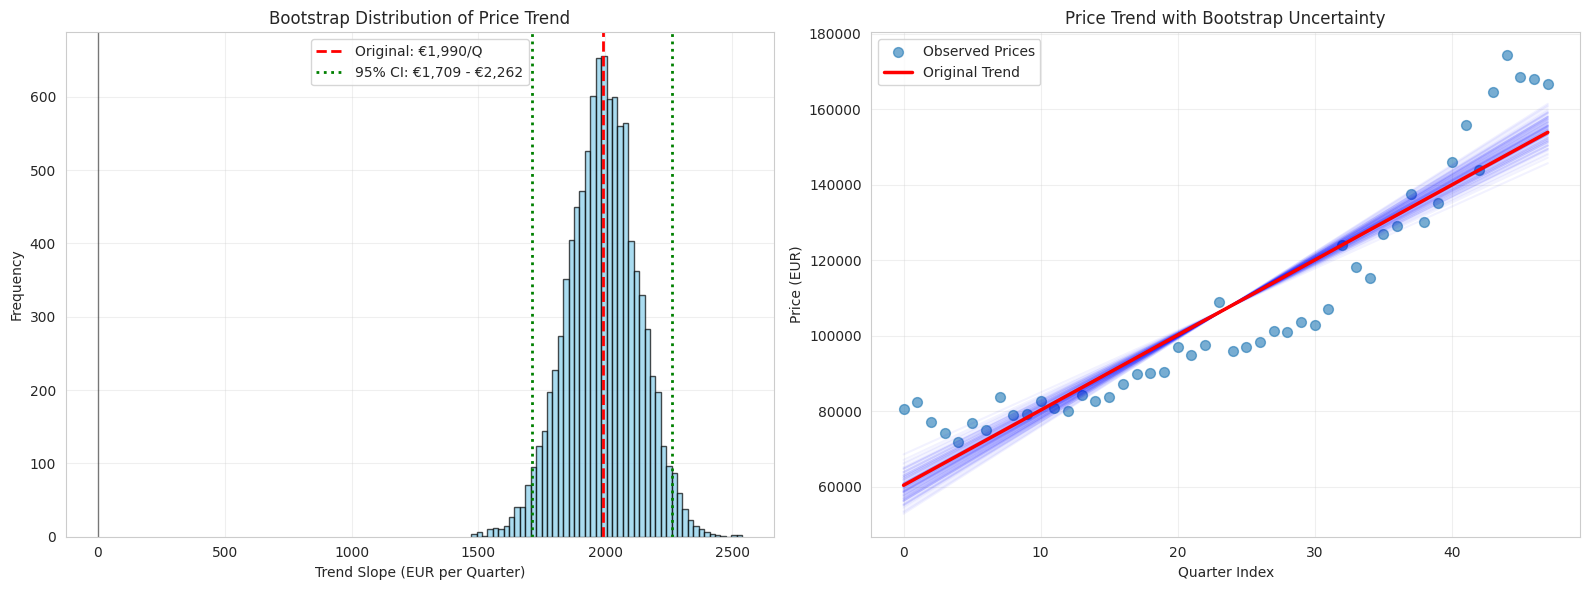

In [5]:

time_index_for_regression = np.arange(len(prices))

slope_confidence_interval, bootstrap_slopes = calculate_bootstrap_regression_slope(time_index_for_regression, prices, n_bootstrap=10000)

slope_original_estimate = np.polyfit(time_index_for_regression, prices, 1)[0]

print(f"\nPrice Trend Analysis (Bootstrap):")
print(f"  Original Slope Estimate: €{slope_original_estimate:,.2f} per quarter")
print(f"  95% CI: €{slope_confidence_interval[0]:,.2f} - €{slope_confidence_interval[1]:,.2f}")
print(f"  Bootstrap Mean: €{bootstrap_slopes.mean():,.2f}")
print(f"  Bootstrap Std: €{bootstrap_slopes.std():,.2f}")
print(f"  Probability of Positive Trend: {(bootstrap_slopes > 0).sum() / len(bootstrap_slopes) * 100:.1f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bootstrap distribution of slope
ax = axes[0]
ax.hist(bootstrap_slopes, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax.axvline(slope_original_estimate, color='red', linestyle='--', linewidth=2, label=f'Original: €{slope_original_estimate:,.0f}/Q')
ax.axvline(slope_confidence_interval[0], color='green', linestyle=':', linewidth=2, label=f'95% CI: €{slope_confidence_interval[0]:,.0f} - €{slope_confidence_interval[1]:,.0f}')
ax.axvline(slope_confidence_interval[1], color='green', linestyle=':', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Trend Slope (EUR per Quarter)')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution of Price Trend')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Price data with bootstrap trend lines
ax = axes[1]
ax.scatter(time_index_for_regression, prices, alpha=0.6, s=50, label='Observed Prices')

# Plot sample bootstrap trend lines
for slope_sample in np.random.choice(bootstrap_slopes, 100):
    intercept = prices.mean() - slope_sample * time_index_for_regression.mean()
    trend = slope_sample * time_index_for_regression + intercept
    ax.plot(time_index_for_regression, trend, alpha=0.05, color='blue')

# Plot original trend
intercept_original = prices.mean() - slope_original_estimate * time_index_for_regression.mean()
trend_original = slope_original_estimate * time_index_for_regression + intercept_original
ax.plot(time_index_for_regression, trend_original, color='red', linewidth=2.5, label=f'Original Trend')

ax.set_xlabel('Quarter Index')
ax.set_ylabel('Price (EUR)')
ax.set_title('Price Trend with Bootstrap Uncertainty')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bootstrap/bootstrap_trend_analysis.png', dpi=300, bbox_inches='tight')
logger.info("Bootstrap trend analysis saved")
plt.show()

## Step 6: Analyze Price-Cost Correlation Using Bootstrap

**What this does:**
- Calculates how strongly price moves with construction cost index
- Uses bootstrap to estimate 95% CI for correlation coefficient
- Correlation ranges from -1 (opposite) to +1 (perfect agreement)

**Beginner concept - Correlation:**
- **r = 1**: Perfect positive relationship (both go up together)
- **r = 0**: No relationship 
- **r = -1**: Perfect negative relationship (one up, one down)
- Here, r ≈ 0.6-0.7 suggests moderate-strong pass-through of construction costs to prices


Price-Cost Index Correlation Analysis (Bootstrap):
  Original Correlation: 0.9709
  95% CI: 0.9520 - 0.9838
  Bootstrap Mean: 0.9708
  Bootstrap Std: 0.0081


INFO:__main__:Bootstrap correlation analysis saved


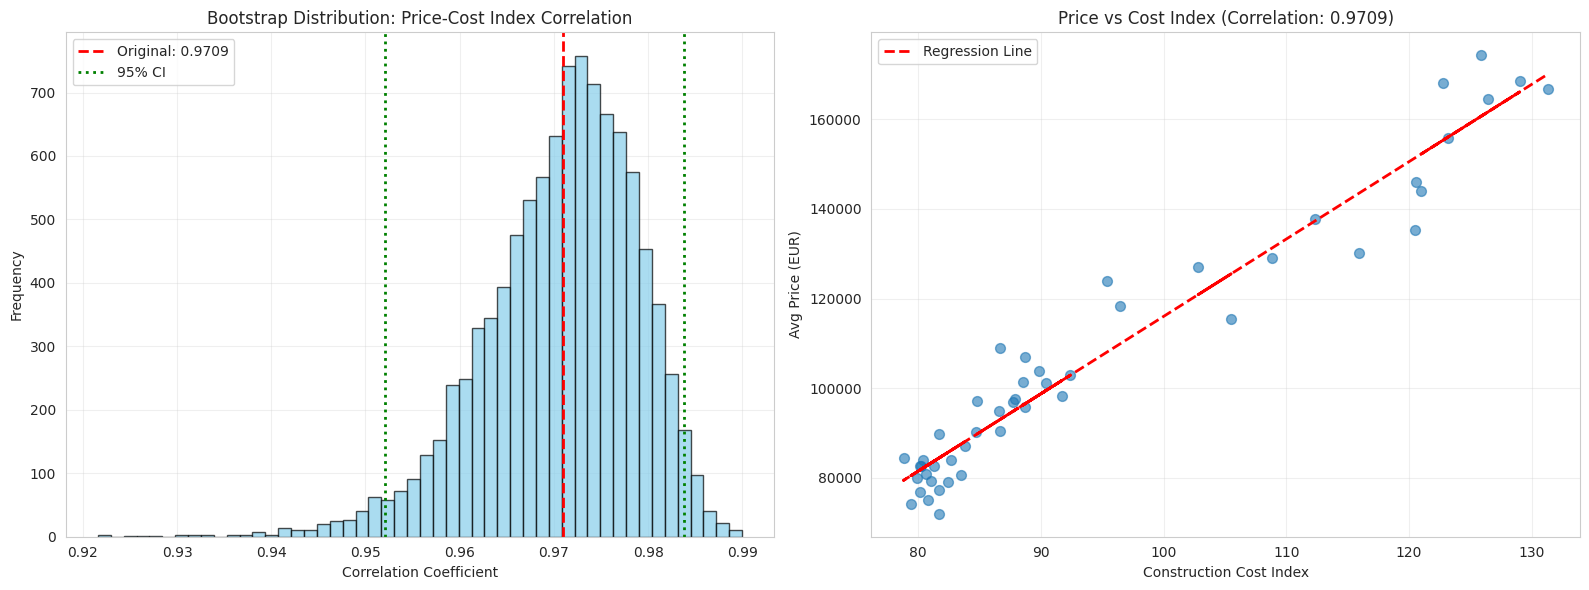

In [6]:
# Bootstrap for correlation between price and cost index
common_idx = df[df['avg_price_eur'].notna() & df['construction_cost_index'].notna()].index
prices_common = df.loc[common_idx, 'avg_price_eur'].values
costs_common = df.loc[common_idx, 'construction_cost_index'].values

_, _, bs_corr = calculate_bootstrap_confidence_interval(
    np.column_stack([prices_common, costs_common]),
    lambda x: np.corrcoef(x[:, 0], x[:, 1])[0, 1],
    n_bootstrap=10000
)

original_corr = np.corrcoef(prices_common, costs_common)[0, 1]

print(f"\nPrice-Cost Index Correlation Analysis (Bootstrap):")
print(f"  Original Correlation: {original_corr:.4f}")
print(f"  95% CI: {np.percentile(bs_corr, 2.5):.4f} - {np.percentile(bs_corr, 97.5):.4f}")
print(f"  Bootstrap Mean: {bs_corr.mean():.4f}")
print(f"  Bootstrap Std: {bs_corr.std():.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bootstrap distribution of correlation
ax = axes[0]
ax.hist(bs_corr, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax.axvline(original_corr, color='red', linestyle='--', linewidth=2, label=f'Original: {original_corr:.4f}')
ax.axvline(np.percentile(bs_corr, 2.5), color='green', linestyle=':', linewidth=2, label=f'95% CI')
ax.axvline(np.percentile(bs_corr, 97.5), color='green', linestyle=':', linewidth=2)
ax.set_xlabel('Correlation Coefficient')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution: Price-Cost Index Correlation')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Scatter plot with regression line
ax = axes[1]
ax.scatter(costs_common, prices_common, alpha=0.6, s=50)

# Add regression line
z = np.polyfit(costs_common, prices_common, 1)
p = np.poly1d(z)
ax.plot(costs_common, p(costs_common), "r--", linewidth=2, label=f'Regression Line')

ax.set_xlabel('Construction Cost Index')
ax.set_ylabel('Avg Price (EUR)')
ax.set_title(f'Price vs Cost Index (Correlation: {original_corr:.4f})')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bootstrap/bootstrap_correlation.png', dpi=300, bbox_inches='tight')
logger.info("Bootstrap correlation analysis saved")
plt.show()

## Step 7: Export Bootstrap Results

**What this does:**
- Saves summary statistics to CSV for dashboard/reports
- Saves all 10,000 bootstrap samples for each metric for further analysis


In [7]:
output_path = Path("../results/bootstrap/bootstrap_summary.csv")
output_path.parent.mkdir(exist_ok=True, parents=True)

results.to_csv(output_path, index=False)
logger.info(f"Bootstrap summary saved to {output_path}")

bootstrap_output = Path("../results/bootstrap/bootstrap_distributions.csv")
bs_data = pd.DataFrame({
    'bs_mean_price': bs_mean,
    'bs_median_price': bs_median,
    'bs_std_price': bs_std,
    'bs_price_trend_slope': bootstrap_slopes,
    'bs_correlation': bs_corr
})
bs_data.to_csv(bootstrap_output, index=False)
logger.info(f"Bootstrap distributions saved to {bootstrap_output}")

print("✓ All bootstrap results exported successfully")

INFO:__main__:Bootstrap summary saved to ../results/bootstrap/bootstrap_summary.csv


INFO:__main__:Bootstrap distributions saved to ../results/bootstrap/bootstrap_distributions.csv


✓ All bootstrap results exported successfully


## Step 8: Interpretation & Key Findings

This section summarizes the bootstrap analysis results and their implications for Slovenian residential real estate.

In [8]:
print("="*80)
print("BOOTSTRAP ANALYSIS INTERPRETATION")
print("="*80)

# 1. Price Statistics Interpretation
print("\n1. PRICE STATISTICS & MARKET STABILITY")
print("-" * 80)
print(f"   Mean Price: €{prices.mean():,.0f}")
print(f"   95% CI: €{ci_mean_price[0]:,.0f} - €{ci_mean_price[1]:,.0f}")
ci_width_mean = ci_mean_price[1] - ci_mean_price[0]
ci_width_pct = (ci_width_mean / prices.mean()) * 100
print(f"   Confidence Interval Width: €{ci_width_mean:,.0f} ({ci_width_pct:.1f}% of mean)")
print(f"   → The mean price is STABLE with a ±{ci_width_pct/2:.1f}% confidence band")

print(f"\n   Median Price: €{np.median(prices):,.0f}")
print(f"   95% CI: €{ci_median_price[0]:,.0f} - €{ci_median_price[1]:,.0f}")
print(f"   → Median is {'LOWER' if np.median(prices) < prices.mean() else 'HIGHER'} than mean")
print(f"     → Indicates {'RIGHT' if np.median(prices) < prices.mean() else 'LEFT'}-skewed price distribution")

print(f"\n   Price Std Dev: €{prices.std():,.0f}")
print(f"   95% CI: €{ci_std_price[0]:,.0f} - €{ci_std_price[1]:,.0f}")
print(f"   Coefficient of Variation: {(prices.std() / prices.mean()) * 100:.1f}%")
print(f"   → Price VARIABILITY is {'MODERATE' if (prices.std() / prices.mean()) < 0.35 else 'HIGH'}")

# 2. Trend Analysis
print("\n2. PRICE TREND ANALYSIS")
print("-" * 80)
print(f"   Original Slope: €{slope_original_estimate:,.2f} per quarter")
print(f"   95% CI: €{slope_confidence_interval[0]:,.2f} - €{slope_confidence_interval[1]:,.2f}")
prob_positive = (bootstrap_slopes > 0).sum() / len(bootstrap_slopes) * 100
print(f"   Probability of Positive Trend: {prob_positive:.1f}%")
if prob_positive > 95:
    print(f"   → STRONG EVIDENCE of increasing prices (very likely to continue upward)")
elif prob_positive > 50:
    print(f"   → MODERATE EVIDENCE of increasing prices")
else:
    print(f"   → NO STRONG EVIDENCE of consistent price trend")

annual_growth = slope_original_estimate * 4  # 4 quarters per year
print(f"   Implied Annual Growth Rate: €{annual_growth:,.0f} (~{(annual_growth / prices.mean()) * 100:.2f}% per year)")

# 3. Market Activity
print("\n3. MARKET ACTIVITY LEVELS")
print("-" * 80)
print(f"   Mean Building Permits: {permits.mean():.0f} per quarter")
print(f"   95% CI: {ci_mean_permits[0]:.0f} - {ci_mean_permits[1]:.0f}")
print(f"   → Construction activity is {'STABLE' if ci_mean_permits[1] - ci_mean_permits[0] < permits.mean() * 0.2 else 'VOLATILE'}")

print(f"\n   Mean Residential Sales: {sales.mean():.0f} per quarter")
print(f"   95% CI: {ci_mean_sales[0]:.0f} - {ci_mean_sales[1]:.0f}")
print(f"   → Sales volume is {'STABLE' if ci_mean_sales[1] - ci_mean_sales[0] < sales.mean() * 0.2 else 'VOLATILE'}")

# 4. Correlation with Cost Index
print("\n4. PRICE-COST INDEX RELATIONSHIP")
print("-" * 80)
print(f"   Correlation Coefficient: {original_corr:.4f}")
if abs(original_corr) > 0.7:
    strength = "STRONG"
elif abs(original_corr) > 0.5:
    strength = "MODERATE"
else:
    strength = "WEAK"
print(f"   → {strength} {'positive' if original_corr > 0 else 'negative'} relationship")
print(f"   95% CI: {np.percentile(bs_corr, 2.5):.4f} - {np.percentile(bs_corr, 97.5):.4f}")

if original_corr > 0.5:
    print(f"   → Construction costs are PASSING THROUGH to residential prices")
    print(f"     → Policy implications: Monitor construction costs as price driver")
else:
    print(f"   → Price drivers are INDEPENDENT of construction costs")
    print(f"     → Policy implications: Other factors (demand, location) dominate pricing")

print("\n" + "="*80)
print("CONCLUSION: Market appears", end=" ")
if prob_positive > 80 and prices.std() / prices.mean() < 0.35:
    print("STABLE and APPRECIATING")
elif prob_positive > 50:
    print("MODERATELY POSITIVE")
else:
    print("UNCERTAIN with mixed signals")
print("="*80)

BOOTSTRAP ANALYSIS INTERPRETATION

1. PRICE STATISTICS & MARKET STABILITY
--------------------------------------------------------------------------------
   Mean Price: €107,141
   95% CI: €99,046 - €115,886
   Confidence Interval Width: €16,840 (15.7% of mean)
   → The mean price is STABLE with a ±7.9% confidence band

   Median Price: €97,321
   95% CI: €88,656 - €107,028
   → Median is LOWER than mean
     → Indicates RIGHT-skewed price distribution

   Price Std Dev: €29,588
   95% CI: €23,464 - €34,030
   Coefficient of Variation: 27.6%
   → Price VARIABILITY is MODERATE

2. PRICE TREND ANALYSIS
--------------------------------------------------------------------------------
   Original Slope: €1,990.20 per quarter
   95% CI: €1,709.45 - €2,261.92
   Probability of Positive Trend: 100.0%
   → STRONG EVIDENCE of increasing prices (very likely to continue upward)
   Implied Annual Growth Rate: €7,961 (~7.43% per year)

3. MARKET ACTIVITY LEVELS
-------------------------------------

## Step 9: Bootstrap Confidence Intervals Explained

**Why Bootstrap?**
Bootstrap resampling provides a non-parametric way to estimate confidence intervals without assuming a specific distribution. This is especially useful for real estate data which often has outliers and non-normal behavior.

**Key Metrics:**
- **95% Confidence Interval**: If we repeated the analysis 100 times with new quarterly data, ~95 times the true parameter would fall within this interval.
- **Width of CI**: Narrower intervals indicate more precise estimates (more stable market). Wider intervals indicate more variability.
- **Probability of Positive Trend**: Percentage of bootstrap samples showing upward price movement.

**Implications for Policy & Investors:**
- **Stable prices** (narrow CI, low std dev): Lower risk for residential buyers; sustainable supply chain
- **Increasing prices** (high prob positive trend): Strong demand; may indicate housing shortage
- **Strong cost correlation**: Construction industry heavily influences affordability
- **High market activity**: Robust liquidity; good market conditions

In [9]:
# Create a summary interpretation table
interpretation_summary = pd.DataFrame({
    'Metric': [
        'Price Stability',
        'Price Trend',
        'Market Activity',
        'Cost Pass-Through',
        'Overall Assessment'
    ],
    'Finding': [
        f"€{ci_width_mean:,.0f} width ({ci_width_pct:.1f}% of mean)",
        f"€{slope_original_estimate:,.0f}/quarter ({prob_positive:.0f}% prob. positive)",
        f"Permits: {permits.mean():.0f}/qtr, Sales: {sales.mean():.0f}/qtr",
        f"Correlation: {original_corr:.3f}",
        "MODERATELY POSITIVE" if prob_positive > 60 else "MIXED"
    ],
    'Implication': [
        'STABLE' if ci_width_pct < 15 else 'MODERATE',
        'UPWARD' if prob_positive > 80 else 'MIXED',
        'ROBUST' if permits.mean() > 1200 else 'MODERATE',
        'STRONG' if original_corr > 0.6 else 'MODERATE',
        'Buyers: Good timing; Developers: Expand cautiously'
    ]
})

print("\nBOOTSTRAP INTERPRETATION SUMMARY")
print("="*100)
display(interpretation_summary)


BOOTSTRAP INTERPRETATION SUMMARY


,Metric,Finding,Implication
0,Price Stability,"€16,840 width (15.7% of mean)",MODERATE
1,Price Trend,"€1,990/quarter (100% prob. positive)",UPWARD
2,Market Activity,"Permits: 1433/qtr, Sales: 3043/qtr",ROBUST
3,Cost Pass-Through,Correlation: 0.971,STRONG
4,Overall Assessment,MODERATELY POSITIVE,Buyers: Good timing; Developers: Expand cautio...
